# Paper implementation : "Changepoint prediction in the presence of outliers"

## When the signal has many outliers, classical change point detection methods fail

We first try classical methods of changepoint detection using the package [Ruptures](https://centre-borelli.github.io/ruptures-docs/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ruptures as rpt
import seaborn as sns

In [132]:
#utils

def bwl(y,theta,K):
    if np.abs(y-theta) <= K:
        return (y-theta)**2
    else:
        return K**2
    
    
def huber(y,theta,K):
    if np.abs(y-theta) <= K:
        return (y-theta)**2
    else:
        return 2*K*np.abs(y-theta) - K**2
    
    
def l1(y,theta):
    return np.abs(y-theta)

    
def add_outliers(n_outliers,signal):
    sig_length = signal.size
    outliers = np.random.choice(np.arange(1,sig_length),n_outliers,replace=False)
    test = np.zeros(sig_length)
    test[outliers] = 1
    test = test*np.random.choice([-1,1], sig_length)*np.random.choice(np.arange(1,2),sig_length)*signal.mean()
    test = test.reshape(sig_length,1)
    signal = signal + test
    return signal

In [236]:
n_samples, n_dims, sigma = 1000, 1, 1
n_bkps = 1  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=sigma)

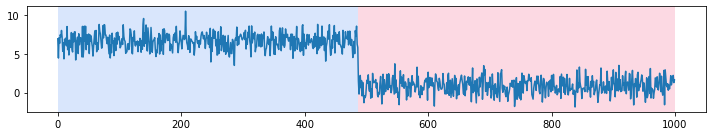

In [237]:
fig, ax_array = rpt.display(signal, bkps)

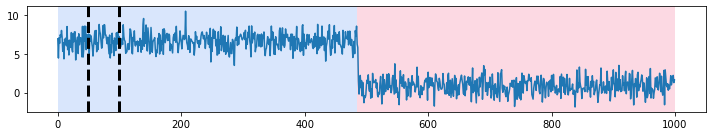

In [241]:
algo = rpt.Pelt(model='l2', min_size=3).fit(signal)
my_bkps = algo.predict(pen=100)
rpt.display(signal, my_bkps, result)
plt.show()

In [136]:
signal= add_outliers(10,signal)

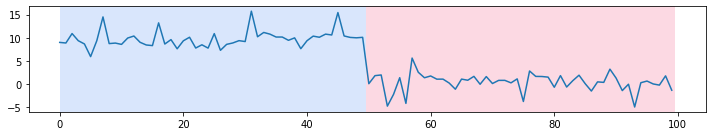

In [137]:
fig, ax_array = rpt.display(signal, bkps)

In [140]:
algo = rpt.Dynp(model="l2").fit(signal)
result = algo.predict(n_bkps=1)

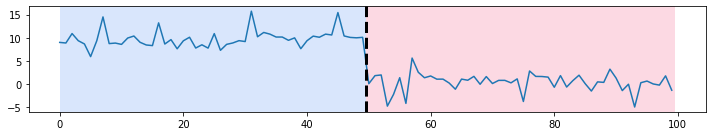

In [141]:
rpt.display(signal, result,bkps)
plt.show()

As one can see, classical changepoint methods fail when the signal has many outliers.

## R-FPOP :  an algorithm robust to outliers

In [242]:
def get_hyperparams(signal):
    
    #if loss == 'biweight'
    sigma = signal.std()
    K = 5*sigma
    somme=0
    n = 100000
    for i in np.arange(n):
        z = np.random.randn()
        if np.abs(z) > K:
            continue
        else:
            somme += (2*z)**2

    somme *= 1/n
    
    beta = 2*(sigma**2)*np.log(signal.size)*somme
    
    return K, beta
    
get_hyperparams(signal)

(15.376272353808961, 520.0986462763442)

In [243]:
signal.size

1000

In [250]:
import tqdm.autonotebook as tqdm
import time
def alg2(Qt_star, tau_star, gamma_t_yt):
    Qt, tau = [], []
    Nt_star = len(Qt_star)
    l = len(gamma_t_yt)
    Nt = 0
    i = 0
    j = 0
    while i < Nt_star and j < l:
        Nt += 1
        a, b = np.max([Qt_star[i][0][0], gamma_t_yt[j][0][0]]), np.min([Qt_star[i][0][1], gamma_t_yt[j][0][1]])
        params = Qt_star[i][1] + gamma_t_yt[j][1]
        Qt.append(((a,b), params))
        tau.append(tau_star[i])
        if b == Qt_star[i][0][1]:
            i += 1
        else:
            j += 1
    return Qt, tau

def alg3(Qt, tau):
    Qt_min = np.inf
    tau_min = 0
    i = 0
    for (a, b), params in Qt:
        if params[0] > 0:
            global_minimizer = -params[1]/2/params[0]
            global_min_value = -params[1]**2/(4*params[0]) + params[2] 
            if global_minimizer >= a and global_minimizer <= b : 
                m = global_min_value
            else:
                m = min(params[0]*(a**2) + params[1]*a + params[2],params[0]*(b**2) + params[1]*b + params[2])
        else:
            m = min(params[0]*(a**2) + params[1]*a + params[2],params[0]*(b**2) + params[1]*b + params[2])
        if m < Qt_min:
            Qt_min = m
            tau_min = tau[i]
        i += 1
    return Qt_min, tau_min

def alg4(t, Qt, tau, C):
    Qt_star, tau_star = [], []
    i = 0
    for (x0, x1), params in Qt:
        a, b, c = params
        if a > 0:
            delta = b*b - 4*a*(c - C)
            if delta > 0:
                roots = [(-b-np.sqrt(delta))/2/a, (-b+np.sqrt(delta))/2/a]
            elif delta == 0:
                roots = [-b/2/a]
            else:
                Qt_star.append(((x0, x1), np.array([0, 0, C])))
                tau_star.append(t)
                break
            r = [x0] + sorted(roots) + [x1]
            for j in range(len(r) - 1):
                if len(roots)==1 or (j%2):
                    Qt_star.append(((r[j], r[j+1]), np.array([0, 0, C])))
                    tau_star.append(t)
                else:
                    Qt_star.append(((r[j], r[j+1]), params))
                    tau_star.append(tau[i])
        elif b != 0: #degree 1
            root = (C - c) / b
            r = [x0, root, x1]
            for j in range(len(r) - 1):
                if (b>0 and j==0) or (b<0 and j==1):
                    Qt_star.append(((r[j], r[j+1]), params))
                    tau_star.append(tau[i])
                else:
                    Qt_star.append(((r[j], r[j+1]), np.array([0, 0, C])))
                    tau_star.append(t)
        else:
            if c >= C:
                Qt_star.append(((x0, x1), np.array([0, 0, C])))
                tau_star.append(t)
            else:
                Qt_star.append(((x0, x1), params))
                tau_star.append(tau[i])
        i += 1
    return Qt_star, tau_star


def algo_general(y, gamma,K, beta):
    Qt_star = [((np.min(y), np.max(y)), np.zeros(3))]
    tau_star = [1]
    change_points = []
    for t in tqdm.tqdm(range(len(y))):
        Qt, tau = alg2(Qt_star, tau_star, gamma(y[t],K))
        Qt_min, tau_min = alg3(Qt, tau)
        change_points.append((Qt_min, tau_min))
        Qt_star, tau_star = alg4(t, Qt, tau, Qt_min + beta) 
    return change_points, times

def biweighloss(yt, K):
    first_part = ((-np.inf, yt-K), np.array([0,0,K*K]))
    second_part = ((yt-K, yt+K), np.array([1, -2*yt, yt**2]))
    third_part = ((yt+K, np.inf), np.array([0,0,K*K]))
    return [first_part, second_part, third_part]
    
def huber_loss(yt, K):
    first_part = ((-np.inf, yt-K), np.array([0, -2*K, 2*K*yt - K*K]))
    second_part = ((yt-K, yt+K), np.array([1, -2*yt, yt**2]))
    third_part = ((yt+K, np.inf), np.array([0, 2*K, - 2*K*yt - K*K]))
    return [first_part, second_part, third_part]


K,beta = get_hyperparams(signal)
change_points, times = algo_general(signal, biweighloss,K,(signal.std()**2)*np.log(signal.size))           

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

391


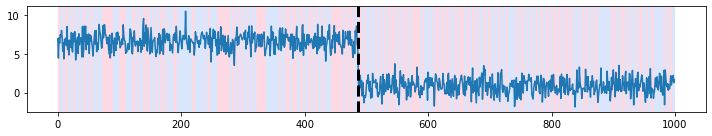

In [251]:
taus = sorted(np.unique([x[1] for x in change_points])) + [len(signal)]
print(len(taus))
fig, ax_array = rpt.display(signal,taus,bkps)

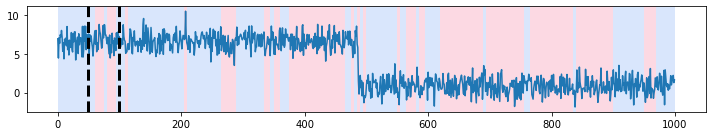

In [252]:
algo = rpt.Pelt(model='l2', min_size=3).fit(signal)
my_bkps = algo.predict(pen=2)
rpt.display(signal, my_bkps, result)
plt.show()

# TO DO

- Régler l'histoire des hyperparamètres
- Comparer avec R
- Tester sur un type de vraies données 
- Rédiger report (4-5p. max)
- Présentation powerpoint 